In [1]:
category_dict = {
    1: 'carrot',
    2: 'cucumber',
    3: 'green bell pepper',
    4: 'green chili pepper',
    5: 'red bell pepper',
    6: 'red chili pepper',
    7: 'eggplant',
    8: 'corn',
    9: 'drawer',
    10: 'chest of drawers',
    11: 'handle',
    12: 'box, basket, case, bin, container',
    13: 'toy cat',
    14: 'white toy',
    15: 'toy block',
    16: 'garlic',
    17: 'tomato',
    18: 'potato',
    19: 'floor',
    20: 'wall',
    21: 'person',
    22: 'key',
    23: 'gripper',
    24: 'door',
    25: 'poster',
    26: 'table',
    27: 'ceiling'
}


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


SelectMultiple(description='Categories', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, …

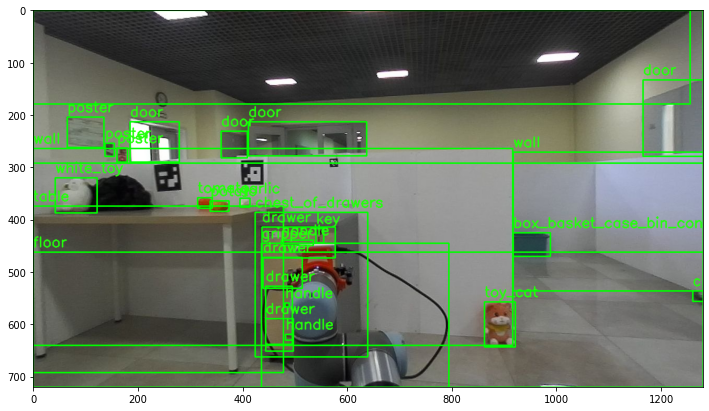

In [3]:
import cv2
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from pycocotools.coco import COCO
import os
# Путь к файлу аннотаций
annotation_file_path = '../dataset/result.json'

# Загрузка COCO аннотаций
coco_annotations = COCO(annotation_file_path)

# Путь к папке с изображениями
image_directory_path = '../dataset/imgs'

# Получение всех уникальных category_id в наборе данных
unique_category_ids = [category['id'] for category in coco_annotations.loadCats(coco_annotations.getCatIds())]

# Создание виджета для выбора категорий
category_selector_widget = widgets.SelectMultiple(
    options=[(category['name'], category['id']) for category in coco_annotations.loadCats(unique_category_ids)],
    value=unique_category_ids,
    description='Categories',
    disabled=False
)
display(category_selector_widget)

def visualize_bounding_boxes(image_id):
    # Загрузка изображения
    image_data = coco_annotations.loadImgs(image_id)[0]
    image_path = os.path.join(image_directory_path, image_data['file_name'])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Получение аннотаций для данного изображения
    annotation_ids = coco_annotations.getAnnIds(imgIds=image_id, catIds=category_selector_widget.value, iscrowd=None)
    annotations = coco_annotations.loadAnns(annotation_ids)

    # Наложение bbox-ов на изображение
    for annotation in annotations:
        x, y, width, height = annotation['bbox']
        image = cv2.rectangle(image, (int(x), int(y)), (int(x+width), int(y+height)), (0, 255, 0), 2)
        cv2.putText(image, coco_annotations.loadCats(annotation['category_id'])[0]['name'], (int(x), int(y-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    # Визуализация результата
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.show()

def on_category_change(change):
    clear_output()
    display(category_selector_widget)
    visualize_bounding_boxes(image_id)

category_selector_widget.observe(on_category_change, 'value')

# Замените image_id на ID изображения, которое вы хотите визуализировать
image_id = 1
visualize_bounding_boxes(image_id)


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
IoU for the bbox = 0.0


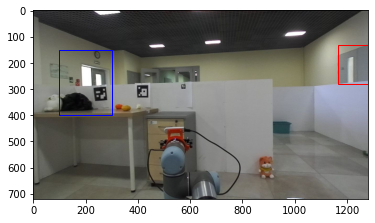

IoU for the bbox = 0.14871156779320863


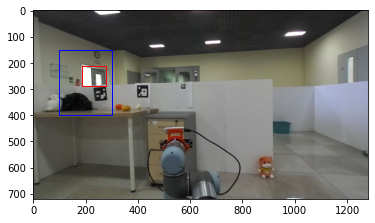

IoU for the bbox = 0.0


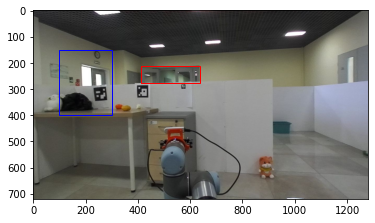

IoU for the bbox = 0.0


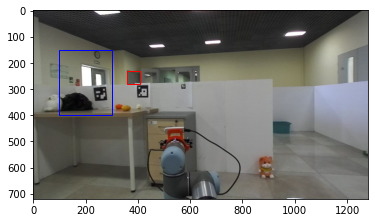

In [11]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import torch
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

# Function to calculate IoU
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_start = max(x1, x2)
    y_start = max(y1, y2)
    x_end = min(x1+w1, x2+w2)
    y_end = min(y1+h1, y2+h2)
    inter_area = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

def get_bboxes(image, text_queries):
   # print(image)
    # Initialize model and processor
    model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
    processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

    # Use GPU if available
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Process image and text inputs
    inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

    # Set model in evaluation mode and move to device
    model = model.to(device)
    model.eval()

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get prediction logits
    logits = torch.max(outputs["logits"][0], dim=-1)
    scores = torch.sigmoid(logits.values).cpu().detach().numpy()

    # Get prediction labels and boundary boxes
    labels = logits.indices.cpu().detach().numpy()
    boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

    # Filter out low score predictions
    score_threshold = 0.1
    result_boxes = [(score, box, label) for score, box, label in zip(scores, boxes, labels) if score >= score_threshold]

    return result_boxes

def plot_bbox(image_path, true_bbox, predicted_bbox):
    # Open the image
    im = np.array(Image.open(image_path), dtype=np.uint8)

    # Create figure and axis
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    # Create a rectangle for the true bbox
    true_rect = patches.Rectangle((true_bbox[0], true_bbox[1]), true_bbox[2], true_bbox[3], 
                                  linewidth=1, edgecolor='r', facecolor='none')

    # Create a rectangle for the predicted bbox
    predicted_rect = patches.Rectangle((predicted_bbox[0], predicted_bbox[1]), predicted_bbox[2], predicted_bbox[3], 
                                       linewidth=1, edgecolor='b', facecolor='none')

    # Add the rectangles to the image
    ax.add_patch(true_rect)
    ax.add_patch(predicted_rect)

    plt.show()


# Load COCO annotations
annotation_file_path = '../dataset/result.json'
coco_annotations = COCO(annotation_file_path)

# Assuming the following data:
image_id = 1
category_id = 24


# Get all annotations for the given image and category
annotation_ids = coco_annotations.getAnnIds(imgIds=image_id, catIds=category_id, iscrowd=None)
annotations = coco_annotations.loadAnns(annotation_ids)

# Get image information
image_info = coco_annotations.loadImgs(image_id)[0]
image_path = os.path.join('../dataset/imgs', image_info['file_name'])
image = plt.imread(image_path)
# Text queries to search the image for
text_queries = ['door', category_dict[category_id]]  # Assuming category_dict is defined
# Get bounding boxes

try:
    predicted_bbox = (get_bboxes(image, text_queries)[0][1]).tolist()
except IndexError:
    predicted_bbox = [100.0, 150.0, 200.0, 250.0] 


# Apply the function
for annotation in annotations:
    true_bbox = annotation['bbox']
    iou = calculate_iou(true_bbox, predicted_bbox)
    print(f'IoU for the bbox = {iou}')
    plot_bbox(image_path, true_bbox, predicted_bbox)


In [3]:
annotations

[]

array([[[0.19215686, 0.19215686, 0.2       ],
        [0.2       , 0.2       , 0.20784314],
        [0.21176471, 0.21176471, 0.21960784],
        ...,
        [0.36862745, 0.37254902, 0.35294118],
        [0.37254902, 0.37647059, 0.35686275],
        [0.37254902, 0.37647059, 0.35686275]],

       [[0.18431373, 0.18431373, 0.19215686],
        [0.19215686, 0.19215686, 0.2       ],
        [0.20784314, 0.20784314, 0.21568627],
        ...,
        [0.36862745, 0.37254902, 0.35294118],
        [0.37254902, 0.37647059, 0.35686275],
        [0.37254902, 0.37647059, 0.35686275]],

       [[0.16862745, 0.16862745, 0.17647059],
        [0.17254902, 0.17254902, 0.18039216],
        [0.18823529, 0.18823529, 0.19607843],
        ...,
        [0.36862745, 0.37254902, 0.35294118],
        [0.37254902, 0.37647059, 0.35686275],
        [0.37647059, 0.38039216, 0.36078431]],

       ...,

       [[0.3372549 , 0.3372549 , 0.29019608],
        [0.3372549 , 0.3372549 , 0.29019608],
        [0.3372549 , 0